# **Missingness: identification & handling**

**Learning objectives**
- Identify types and patterns of missing data.
- Apply practical strategies: drop, simple imputation, indicator variables.
- Use advanced imputation: IterativeImputer (model-based) and a sketch of a LightGBM-based imputer.
- Understand pitfalls: leakage, distributional changes, and how to use imputation safely in cross-validation.

**Prerequisites**: Python, pandas, numpy, scikit-learn; basic ML concepts (train/test split, pipelines).


## **Why missingness matters**
Missing values are extremely common in real-world data and can bias models, break preprocessing pipelines, or reduce effective sample size.

Common causes:
- Data entry errors or sensor dropouts
- Different data collection processes (missing not at random)
- Design: some columns are only present for certain groups

We’ll walk from detection → simple fixes → model-based imputation → best practices.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/NBA_Dataset_csv.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Team                            159 non-null    object 
 1   Points_Scored                   159 non-null    int64  
 2   Weightlifting_Sessions_Average  150 non-null    float64
 3   Yoga_Sessions_Average           139 non-null    float64
 4   Laps_Run_Per_Practice_Average   145 non-null    float64
 5   Water_Intake                    145 non-null    float64
 6   Players_Absent_For_Sessions     130 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


In [ ]:
data.head()

,Team,Points_Scored,Weightlifting_Sessions_Average,Yoga_Sessions_Average,Laps_Run_Per_Practice_Average,Water_Intake,Players_Absent_For_Sessions
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


In [ ]:
df = data.rename(columns={'Points_Scored':'Points','Weightlifting_Sessions_Average':'WL','Yoga_Sessions_Average':'Yoga',
                        'Laps_Run_Per_Practice_Average':'Laps','Water_Intake':'WI',
                        'Players_Absent_For_Sessions':'PAFS'})

In [ ]:
df.head()

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


## **Identifying Missingness**

Before we can handle missing values, we need to **identify** them in our dataset. Missing data can occur for many reasons — errors during data collection, incomplete records, system glitches, or even intentional omission.

Understanding **where** and **how** missingness appears is crucial because it influences the strategy we use to handle it. If we blindly fill or drop values, we might introduce bias or lose important information.

---

### **Types of Missing Data**

When analyzing missingness, statisticians often classify it into three categories:

1. **MCAR (Missing Completely At Random)**

   * The missing values have no relationship with the data itself (observed or unobserved).
   * Example: a survey response accidentally lost during data entry.
   * Safe to ignore or impute without introducing bias.

2. **MAR (Missing At Random)**

   * Missingness depends only on the **observed data**.
   * Example: income is missing more often for younger respondents, but if age is recorded, we can model the missingness.

3. **MNAR (Missing Not At Random)**

   * Missingness depends on the **unobserved value itself**.
   * Example: people with very high incomes are less likely to report their salary.
   * Hardest to handle, may require domain expertise or advanced imputation.

---

### **Tools for Identifying Missingness**

We’ll use both **pandas** utilities and the **`missingno`** library to visualize and quantify missing data in our NBA dataset.

#### Using Pandas

* `df.isnull().sum()` → count of missing values per column.
* `df.isnull().mean()` → percentage of missing values per column.
* `df.info()` → quick overview of non-null counts across columns.

#### Using `missingno` (msno)

The `missingno` library gives us visual diagnostics:

* `msno.bar(df)` → bar chart of missing values per column.
* `msno.matrix(df)` → matrix showing the distribution and patterns of missingness across rows.
* `msno.heatmap(df)` → correlation heatmap showing whether missingness in one column is related to another.

---

**Why is this important?**

Because the type and pattern of missingness determine the right strategy:

* If MCAR: we might drop rows safely.
* If MAR: we can impute using observed variables.
* If MNAR: we may need deeper modeling or accept some uncertainty.


## 1) **Basic missingness summary**

Start with simple numeric summaries:
- `isnull().sum()` shows raw counts
- `isnull().mean()` gives percentage missing

These quickly show which columns need attention.


In [ ]:
missing = pd.DataFrame({
    "num_missing": df.isnull().sum(),
    "pct_missing": df.isnull().mean() * 100,
    "dtype": df.dtypes.astype(str)
}).sort_values("pct_missing", ascending=False)

missing.style.format({"pct_missing": "{:.2f}"})

,num_missing,pct_missing,dtype
PAFS,29,18.24,float64
Yoga,20,12.58,float64
Laps,14,8.81,float64
WI,14,8.81,float64
WL,9,5.66,float64
Points,0,0.00,int64
Team,0,0.00,object


- Columns with high `% missing` (e.g., > 30–50%) may be candidates for dropping or special treatment.

- Columns with small % missing can often be imputed with simple strategies, but check patterns first.


## 2) **Visual diagnostics with `missingno`**

We’ll use three main plots:
- `msno.bar(df)`: shows the number of non-missing values per column (quick overview).
- `msno.matrix(df)`: shows row-wise patterns of missingness (gaps) and helps spot blocks of missing rows.
- `msno.heatmap(df)`: shows correlations between missingness in different columns (helpful to find MAR patterns).


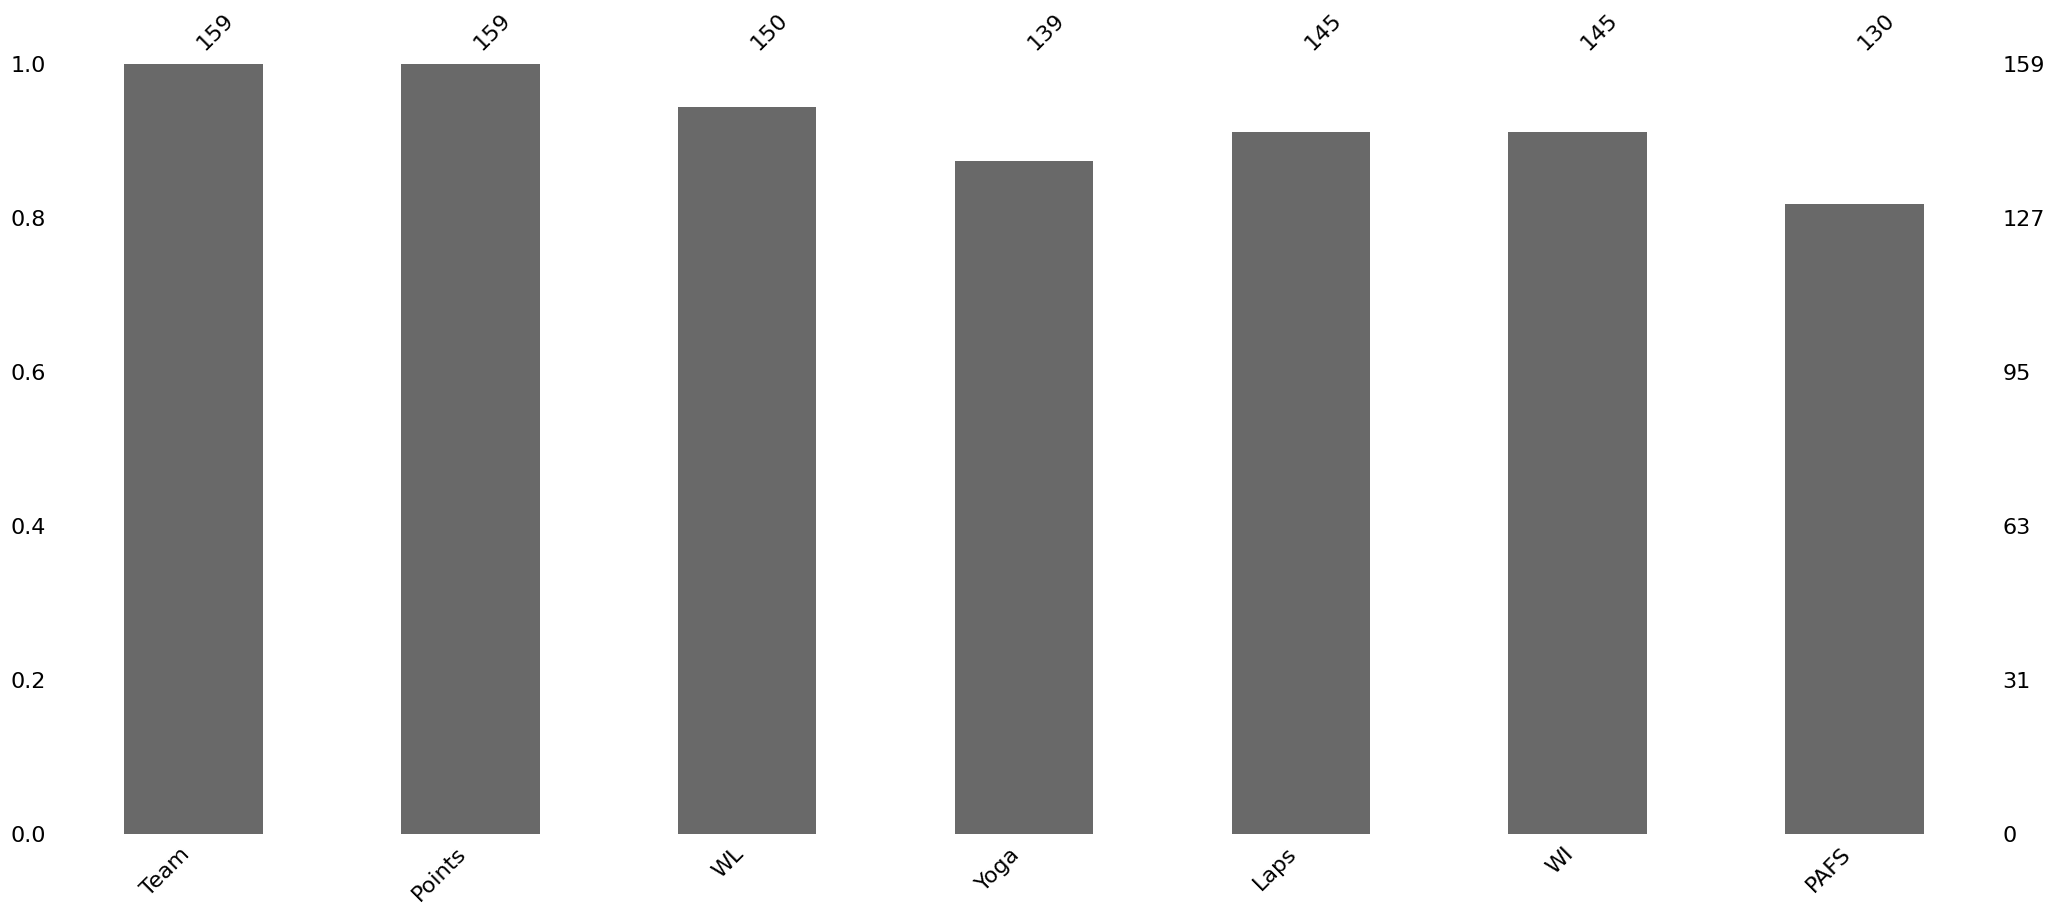

In [ ]:
# Bar Chart
msno.bar(df)
plt.show()

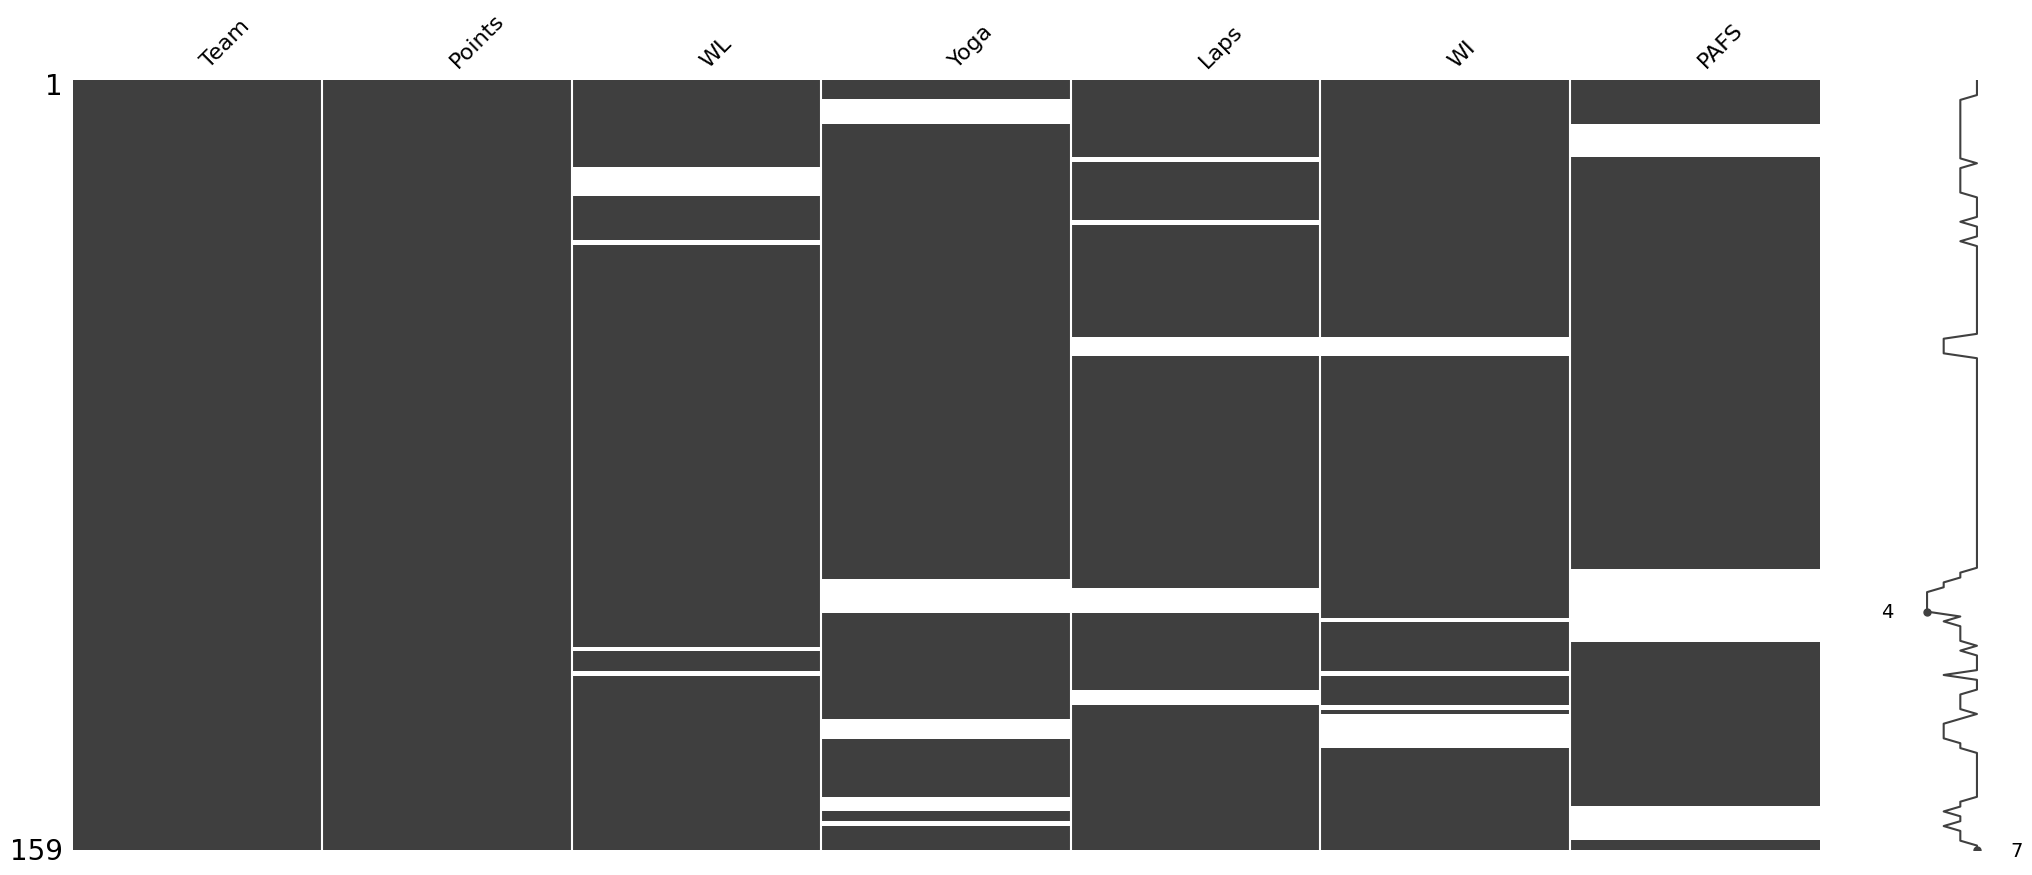

In [ ]:
# Matrix - row-wise pattern
msno.matrix(df)
plt.show()

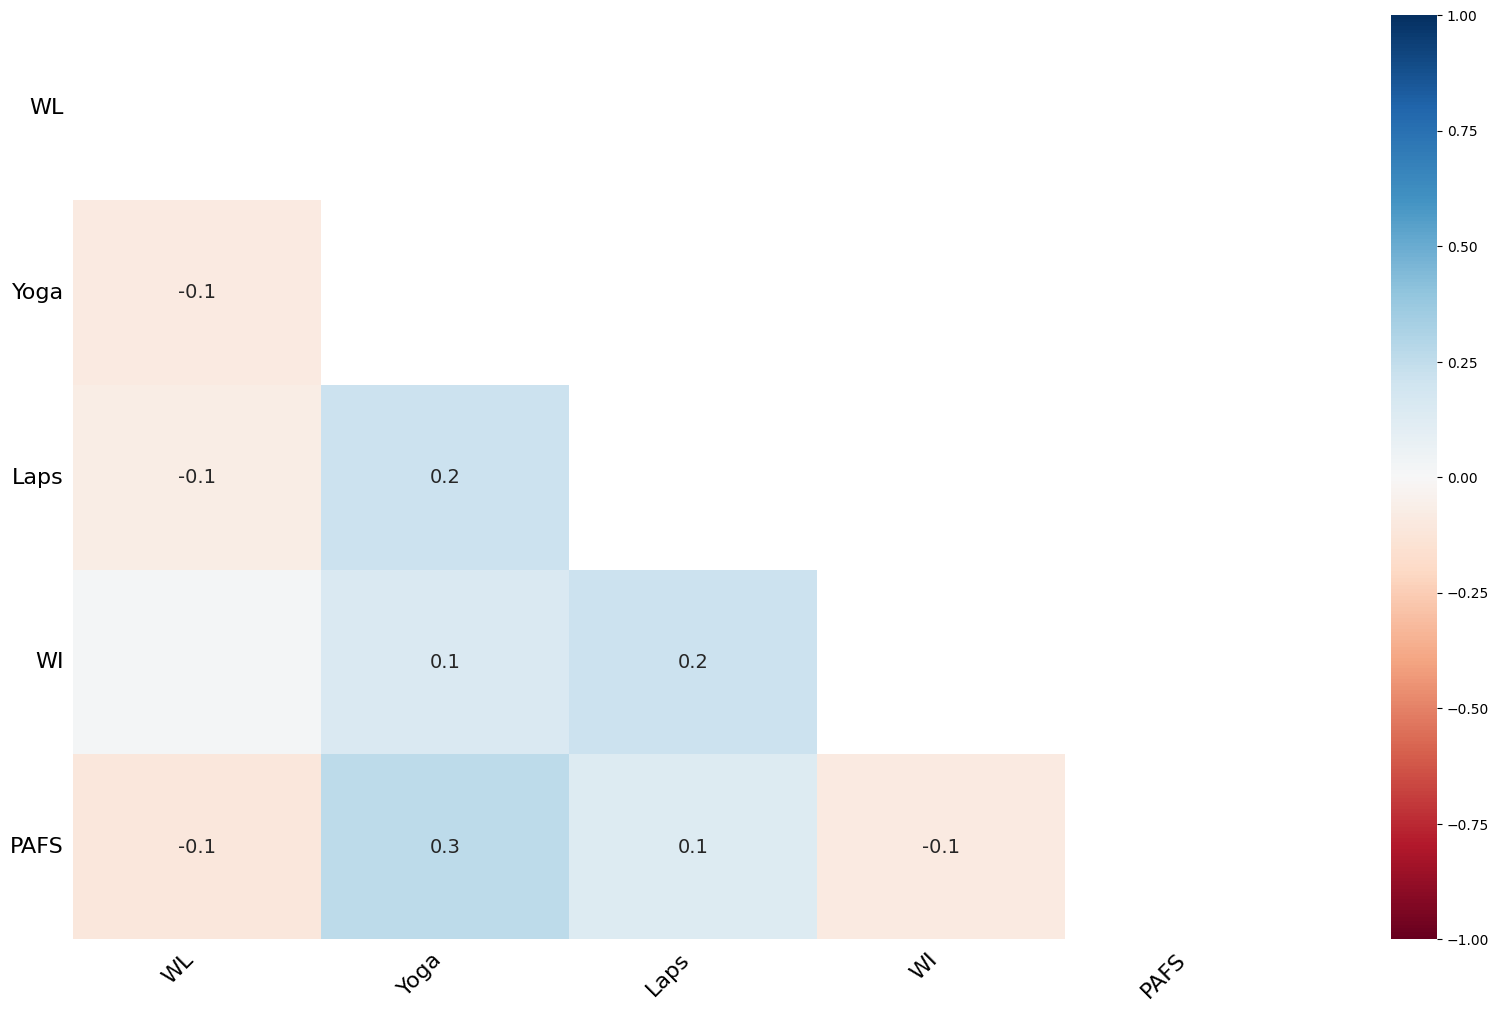

In [ ]:
# Heatmap - correlation of missingness
msno.heatmap(df)
plt.show()

- `msno.bar`: quickly flags which columns are most affected.
- `msno.matrix`: vertical white gaps mean entire rows missing for a set of columns — could be data ingestion issues or group-specific records.
- `msno.heatmap`: strong positive correlation between missing indicators for two columns suggests their missingness is related (possible MAR). A near-zero correlation does not prove MCAR, but reduces evidence of MAR.


In [ ]:
missing_values = df.isnull().any()

columns_with_missing_values = missing_values[missing_values == True].index

# Step 3: Extract the columns with missing values from the dataset
df_missing_values = df[columns_with_missing_values]

In [ ]:
df_missing_values

,WL,Yoga,Laps,WI,PAFS
0,23.0,25.0,30.0,5.0,4.0
1,24.0,26.0,31.0,5.0,8.0
2,24.0,27.0,31.0,5.0,7.0
3,26.0,29.0,34.0,5.0,1.0
4,27.0,NaN,34.0,5.0,6.0
...,...,...,...,...,...
154,12.0,12.0,13.0,1.0,NaN
155,12.0,12.0,14.0,1.0,NaN
156,12.0,13.0,14.0,1.0,NaN
157,13.0,14.0,15.0,1.0,6.0


## **Exploring Distributions Before Imputation**

Before deciding how to handle missing values, it is good practice to examine the **distribution of each variable**.

Why this matters:
- The choice of imputation method should respect the underlying distribution of the data.
- If a variable is normally distributed, imputing with the **mean** is often reasonable.
- If a variable is skewed, the **median** is more robust and avoids distortion by outliers.
- For categorical variables, we often impute with the **mode** or a new category (e.g., `"Unknown"`).
- Some variables may have **multiple peaks (multimodal)** — in such cases, single-value imputation may not be appropriate, and model-based imputation may perform better.

By visualizing the distributions (histograms, density plots, boxplots), we can make more informed decisions about imputation strategies.


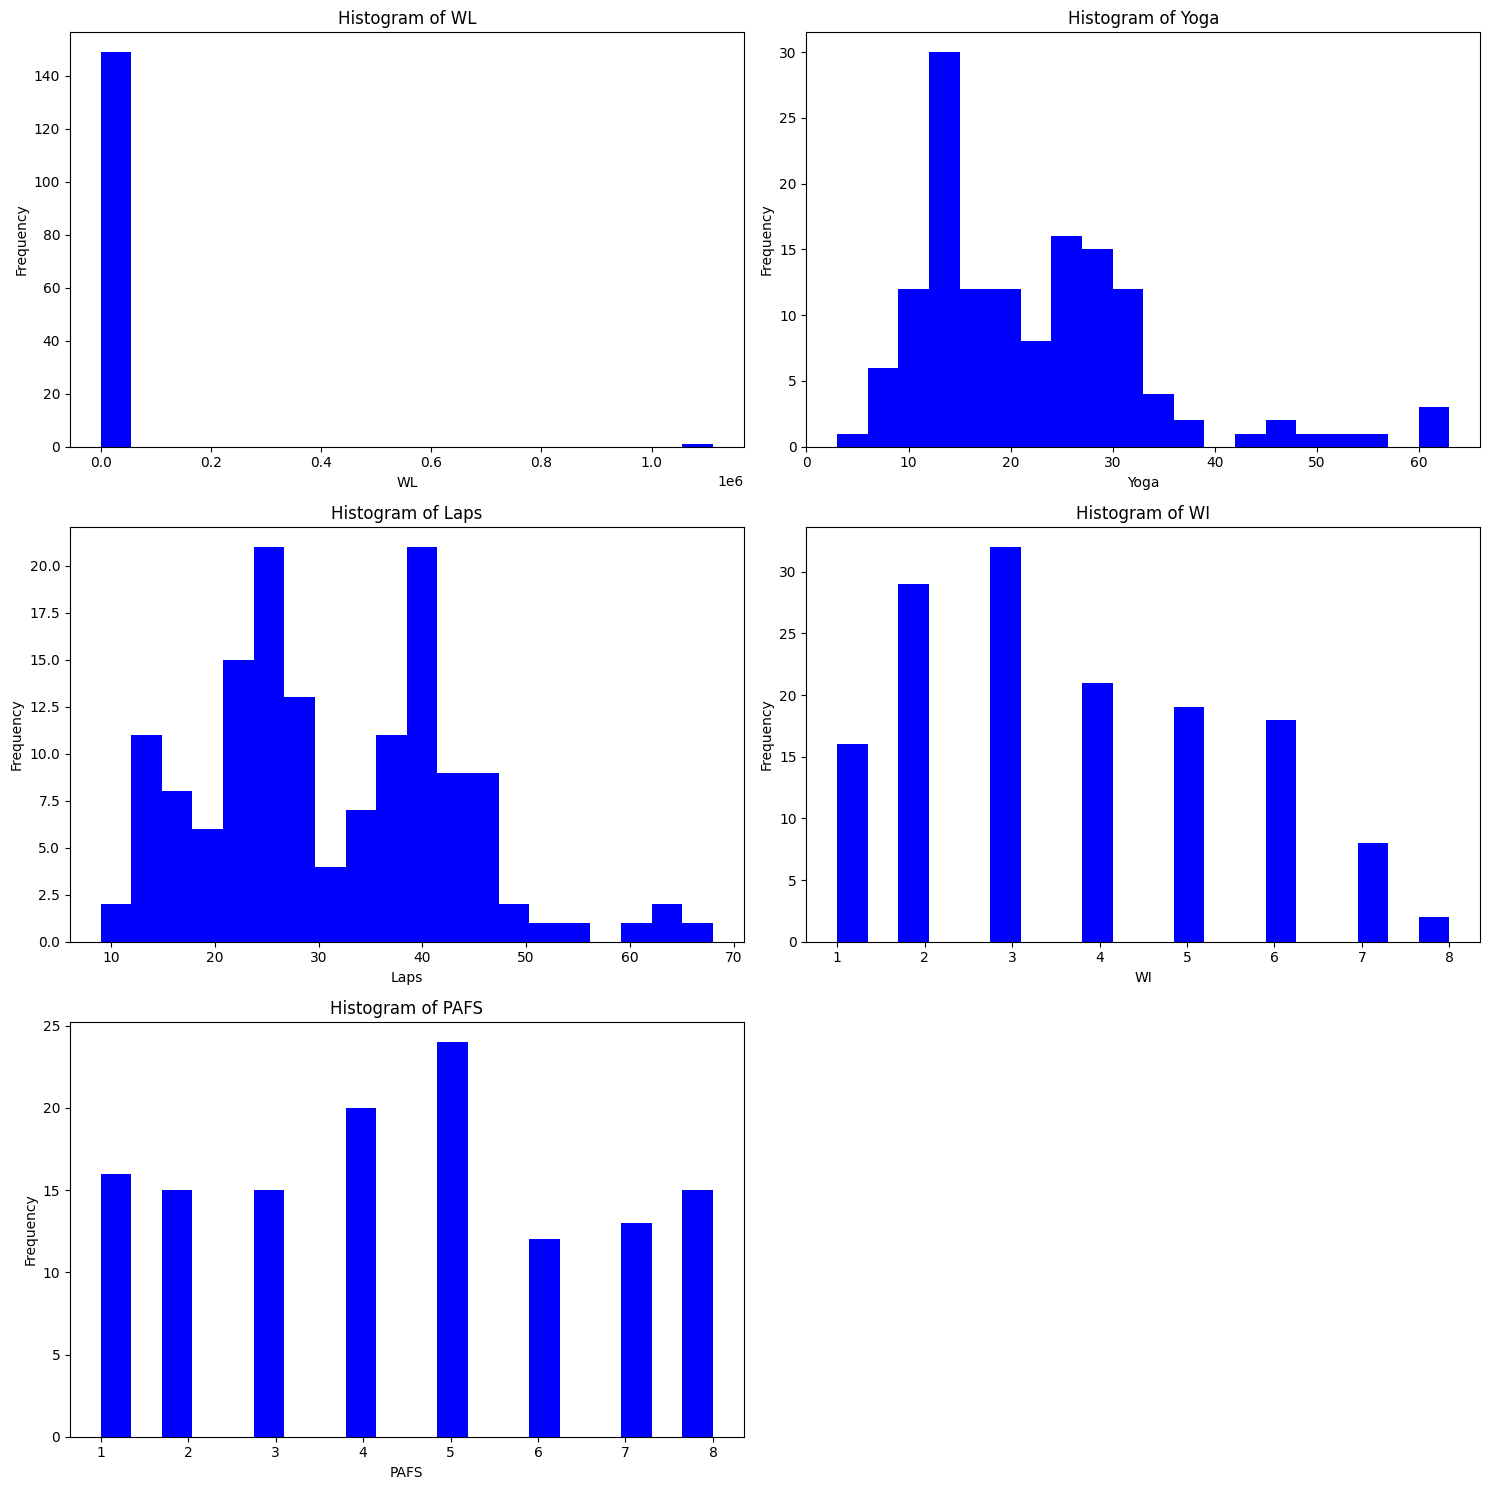

In [ ]:
num_columns = len(df_missing_values.columns)
num_rows = (num_columns + 1) // 2  # Ensure there's at least one row
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot histograms for columns with missing values
for i, column in enumerate(df_missing_values.columns):
    axes[i].hist(df_missing_values[column].dropna(), bins=20, color='blue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplot
for i in range(num_columns, num_rows * 2):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

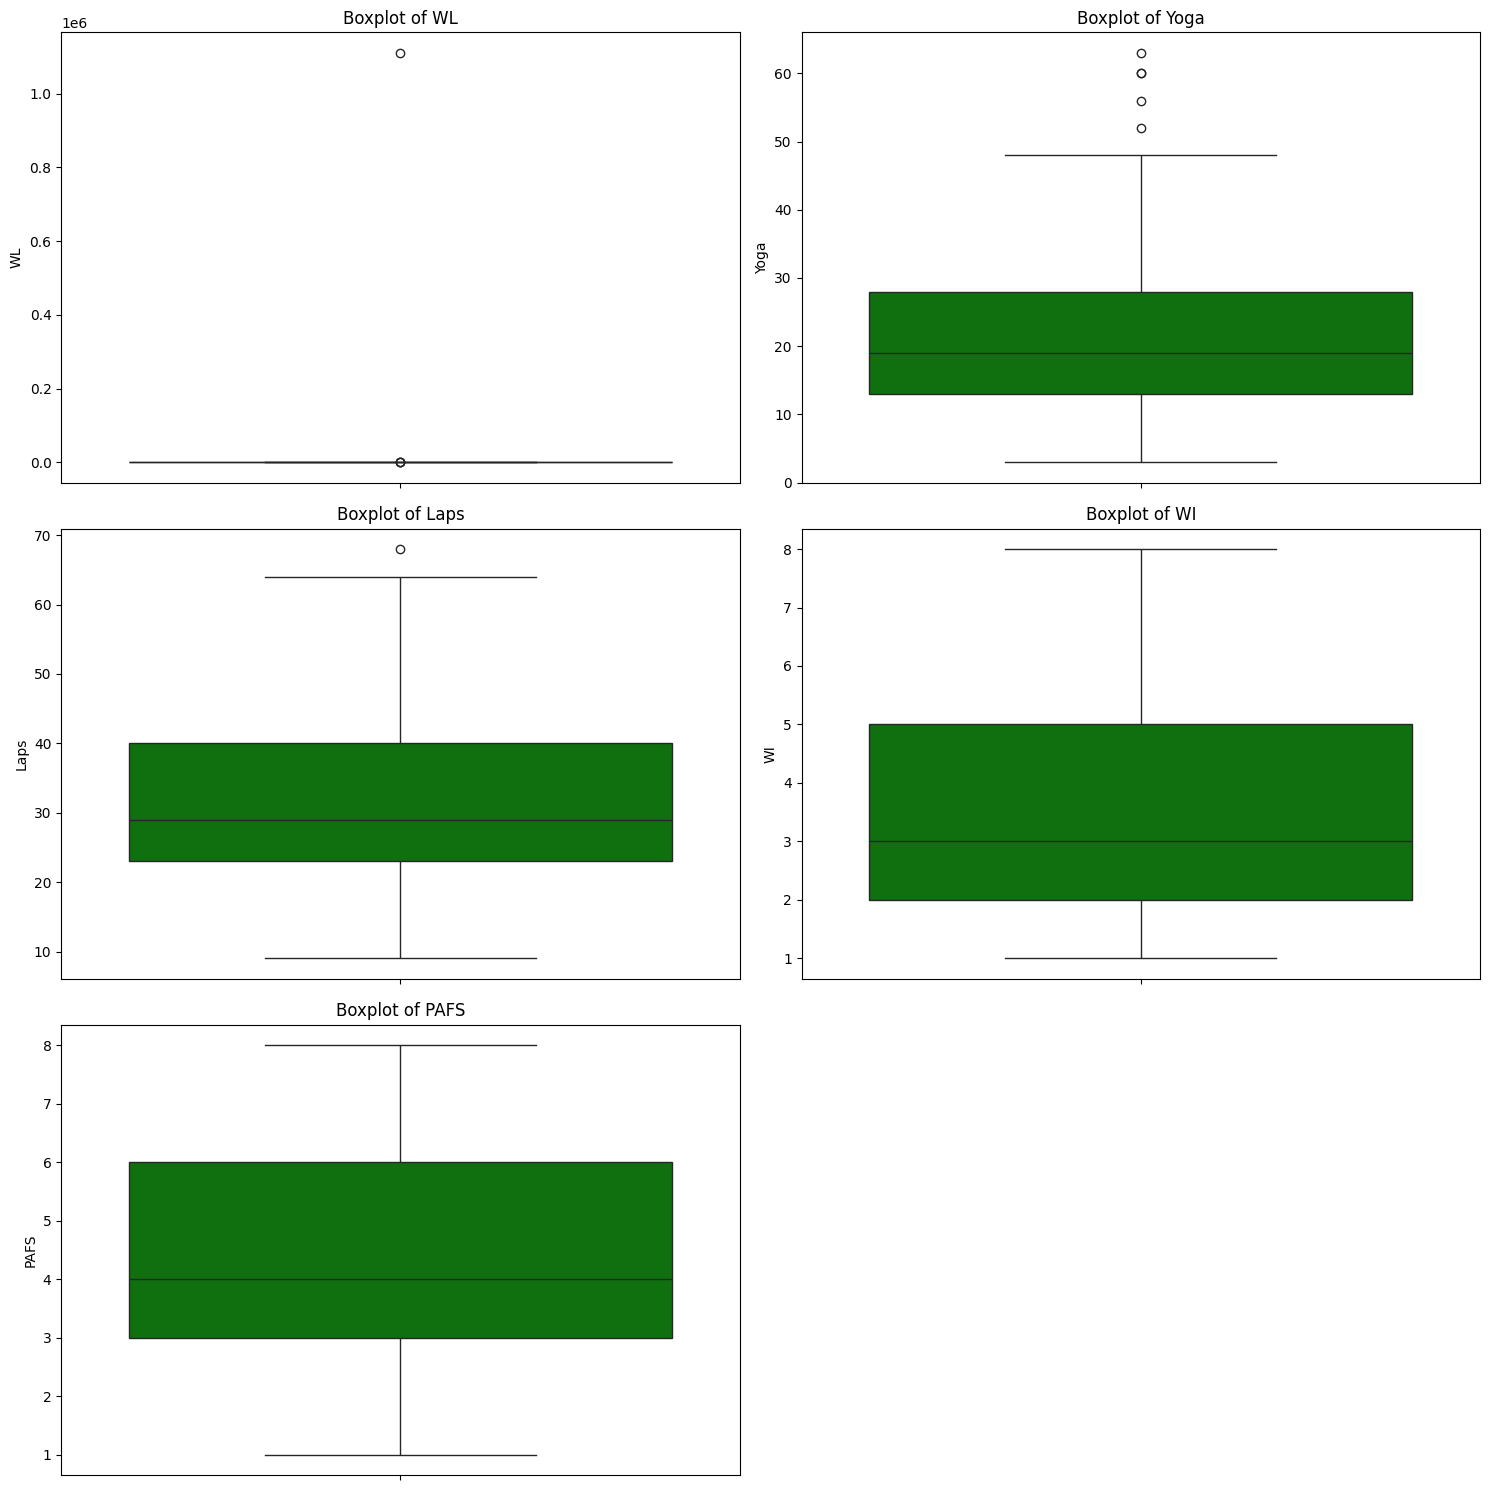

In [ ]:
num_columns = len(df_missing_values.columns)
num_rows = (num_columns + 1) // 2  # Ensure there's at least one row
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot boxplots for columns with missing values
for i, column in enumerate(df_missing_values.columns):
    sns.boxplot(y=df_missing_values[column], color='green', ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

# Remove any unused subplot
for i in range(num_columns, num_rows * 2):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Handling Outliers**

In [ ]:
# The WL column has outliers

print(f" Max Value : {df['WL'].max()}")
print(f" Min Value : {df['WL'].min()}")

 Max Value : 1111111.0
 Min Value : 8.0


In [ ]:
mask = df['WL'] == 1111111.0

filtered_df = df[~mask]
filtered_df.head()

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


In [ ]:
print(f" Max Value : {filtered_df['WL'].max()}")
print(f" Min Value : {filtered_df['WL'].min()}")

 Max Value : 59.0
 Min Value : 8.0


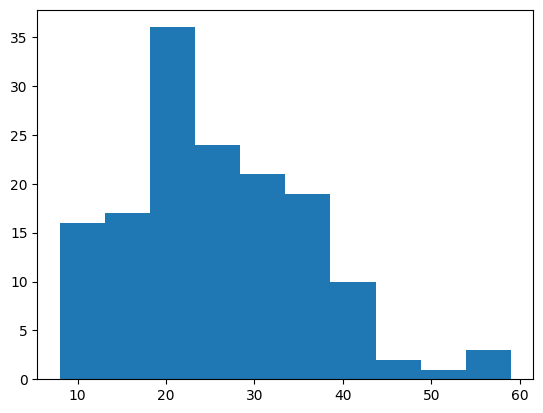

In [ ]:
plt.hist(filtered_df['WL'])
plt.show()

## Handling Missing Values through Imputation

Once we have identified missingness and explored distributions, the next step is to **fill in the gaps** so our data can be used in analysis and modeling. This process is called **imputation**.

There are many ways to impute missing values — from simple replacements with a single statistic, to more advanced model-based approaches. The method we choose depends on:
- the type of variable (numeric vs categorical),
- the distribution of the data,
- and the amount/pattern of missingness.

We will start with simple methods and gradually move to more advanced techniques.

### **1. Pandas Imputation (Mean & Median)**

The simplest way to impute is to replace missing values with a single summary statistic:
- **Mean**: works if the feature is normally distributed and not heavily skewed.
- **Median**: more robust to skewness and outliers.

In Pandas, we can use the `.fillna()` function along with `.mean()` or `.median()`.


**Mean Imputation**

In [ ]:
# Simple mean imputation

mean_wl = filtered_df['WL'].mean()

complete_mean_WL = df['WL'].fillna(mean_wl)

In [ ]:
complete_mean_WL.isnull().sum()

0

In [ ]:
# Imputing with the mean of each Team

team_mean_WL = filtered_df.groupby("Team")['WL'].mean().to_dict()

team_mean_WL

{'Bulls': 11.214285714285714,
 'Clippers': 29.0,
 'Lakers': 26.04255319148936,
 'Porcupines': 42.529411764705884,
 'Trailblazers': 25.425925925925927,
 'Warriors': 18.727272727272727}

In [ ]:
for index, row in filtered_df.iterrows():
    team = row['Team']
    if pd.isna(row['WL']):
        mean_value = filtered_df.get(team)
        filtered_df.at[index, 'WL'] = mean_value

**Median Imputation**

In [ ]:
median_wl = filtered_df['WL'].median()

complete_median_WL = df['WL'].fillna(median_wl)

In [ ]:
complete_median_WL.isnull().sum()

0

### **2. Scikit-learn SimpleImputer**

While Pandas imputation is easy for quick fixes, it does not integrate well into **machine learning pipelines**. For that, we use Scikit-learn’s `SimpleImputer`.

The `SimpleImputer`:
- learns the statistic (mean, median, most_frequent, or constant) from the training data,
- applies it consistently during model training and testing,
- prevents data leakage by fitting only on training folds in cross-validation.

We will demonstrate `SimpleImputer` with `strategy="mean"` and `strategy="median"`.


In [ ]:
# Using mean

from sklearn.impute import SimpleImputer
impt = SimpleImputer(strategy='mean')

In [ ]:
Features=['WL','Yoga','Laps','WI','PAFS']

mean_impt = impt.fit_transform(filtered_df[Features])
mean_impt_df=pd.DataFrame(mean_impt,columns=Features)

mean_impt_df.isnull().sum()

WL      0
Yoga    0
Laps    0
WI      0
PAFS    0
dtype: int64

In [ ]:
impt = SimpleImputer(strategy='median')
Features=['WL','Yoga','Laps','WI','PAFS']

median_impt = impt.fit_transform(filtered_df[Features])
median_impt_df=pd.DataFrame(median_impt,columns=Features)

median_impt_df.isnull().sum()

WL      0
Yoga    0
Laps    0
WI      0
PAFS    0
dtype: int64

# **Model Imputation**

### **3. KNNImputer (K-Nearest Neighbors Imputation)**

Instead of filling missing values with a single statistic, the `KNNImputer` looks at the **nearest neighbors** in feature space and imputes based on their values.

For example, if a player’s height is missing, KNNImputer will find players with similar stats (like weight, position, etc.) and use their height to fill the gap.

- Pros: captures local structure in the data.
- Cons: computationally expensive for large datasets; sensitive to irrelevant features.


In [ ]:
from sklearn.impute import KNNImputer

KNN=KNNImputer(n_neighbors=3)

#Fit & Transform

KNN_impt=KNN.fit_transform(filtered_df[Features])

KNN_impt_df=pd.DataFrame(KNN_impt,columns=Features)

KNN_impt_df.isnull().sum()

WL      0
Yoga    0
Laps    0
WI      0
PAFS    0
dtype: int64

### **4. IterativeImputer (Multivariate Imputation)**

`IterativeImputer` takes imputation a step further. It treats each feature with missing values as a regression problem, predicting missing values using the other available features. This process repeats in cycles (hence "iterative").

This method is powerful because:
- it accounts for relationships between multiple features,
- it can preserve more realistic distributions of the data.

However:
- it is computationally heavier,
- results can vary depending on the model assumptions,
- works best when missingness is MAR (depends on other observed variables).


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

In [ ]:
iterative_imp = imp.fit_transform(filtered_df[Features])

iterative_impt_df=pd.DataFrame(iterative_imp,columns=Features)

In [ ]:
iterative_impt_df.isnull().sum()

WL      0
Yoga    0
Laps    0
WI      0
PAFS    0
dtype: int64

## Summary

- **Mean/Median Imputation (Pandas or SimpleImputer)**: fast, easy, good baseline for numeric data.
- **SimpleImputer with "most_frequent" or "constant"**: useful for categorical features.
- **KNNImputer**: leverages similarity between rows, good for structured data.
- **IterativeImputer**: most flexible and powerful, but slower and more complex.

In practice:
- Always **compare the distribution before and after imputation** to ensure you’re not distorting the data.
- Start with simple methods and only move to advanced ones when necessary.
- Use Scikit-learn imputers inside pipelines to avoid data leakage in ML workflows.
